In [1]:
import sys
!conda install --yes --prefix {sys.prefix} statsmodels seaborn

Channels:
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: done

# All requested packages already installed.



To explain the plots, we will be using the credit score dataset. It contains 84 features for 1000 customers based on their transactions and financial position. We use this dataset to estimate a customer’s credit risk which is given by CREDIT_SCORE. You can find the full description on Kaggle. For this project, we will stick with the 6 features given in Figure 1.

We start with the imports (line 1–10). We then load the credit risk dataset (line 13), select the target variable (line 16) and do some feature engineering. This includes adding a squared term for the R_EXPENDITURE feature (line 19). We add this as both increases and decreases in the expenditure ratio are a sign of higher credit risk. We also create dummy variables for the LOW and HIGH groups of the gambling feature (lines 25–27).

In [2]:
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
import shap

from lets_plot import *
from lets_plot.mapping import as_discrete
from lets_plot.bistro import *
LetsPlot.setup_html()

# Load dataset and add squared term
credit_score = pd.read_csv("../../data/credit_score.csv")

# Target variable
y = credit_score['CREDIT_SCORE']

# Add squared term
credit_score['R_EXPENDITURE_SQR'] = credit_score['R_EXPENDITURE']**2

# Select features
X = credit_score[['INCOME','R_DEBT_INCOME','R_EXPENDITURE','R_EXPENDITURE_SQR','R_ENTERTAINMENT','CAT_GAMBLING']].copy()

# One-hot encoding
X['GAMBLING_LOW'] = X['CAT_GAMBLING'].apply(lambda x: 1 if x == 'Low' else 0)
X['GAMBLING_HIGH']  = X['CAT_GAMBLING'].apply(lambda x: 1 if x == 'High' else 0)
X.drop(columns=['CAT_GAMBLING'], inplace=True)

X.head()

/home/asmirnov/Applications/miniconda3/envs/lets-plot-experiments/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,INCOME,R_DEBT_INCOME,R_EXPENDITURE,R_EXPENDITURE_SQR,R_ENTERTAINMENT,GAMBLING_LOW,GAMBLING_HIGH
0,33269,16.0000,0.5797,0.336052,0.5065,0,1
1,77158,4.0909,0.3580,0.128164,0.5042,0,0
2,30917,17.3000,0.5698,0.324672,0.6178,0,1
3,80657,7.8000,0.4985,0.248502,0.5094,0,1
4,149971,16.0000,0.4604,0.211968,0.5150,0,1


We fit a linear regression model (line 5) and output a summary (line 8). As seen in Figure 2, the summary is a well of knowledge. If you have a statistical background, it would provide most of the insight you need when it comes to understanding the model. The methods we will discuss will help us explain the model to someone who does not have this background.

In [3]:
# Add a constant to the independent variables (intercept)
X = sm.add_constant(X)

# Fit a linear regression model
model = sm.OLS(y, X).fit()

# Output the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     672.1
Date:                Tue, 09 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:18:35   Log-Likelihood:                -4694.1
No. Observations:                1000   AIC:                             9404.
Df Residuals:                     992   BIC:                             9444.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               674.9545     21.51

### Plot 1: residual plot

The first method is the residual plot. In my opinion, this is the best visualisation for understanding the performance of a regression model. In the code below, we create a scatterplot of the model’s predictions (line 2) vs a customer’s actual credit score (line 6). We then add the y=x line in red (line 9). This gives the line of perfect predictions. That is if the model always predicted the actual credit score.

Text(0, 0.5, 'Actual')

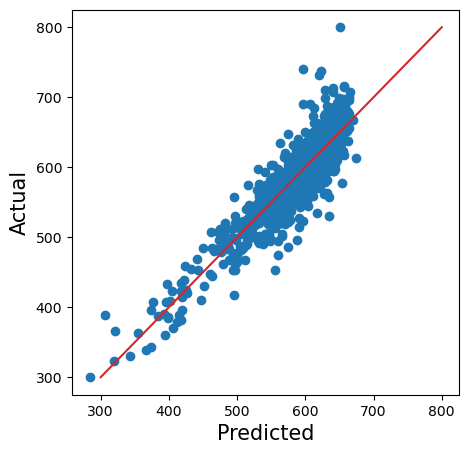

In [4]:
# Figure 3

# Get model predictions
y_pred = model.predict(X)

# Plot predicted vs actual
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_pred,y)

# Plot y=x line
ax.plot([y.min(), y.max()], [y.min(), y.max()], color='tab:red')

plt.xlabel('Predicted',size=15)
plt.ylabel('Actual', size=15)

In [5]:
# Figure 3, Lets-Plot

gggrid([
    ggplot() + \
        geom_point(aes(x=y_pred, y=y)) + \
        geom_segment(x=y.min(), y=y.min(), xend=y.max(), yend=y.max(), color="red") + \
        xlab("Predicted") + ylab("Actual"),
    residual_plot({'y_pred': y_pred, 'y': y}, 'y_pred', 'y')
])

We can see the output in Figure 3. In statistics, a residual is the difference between a model’s prediction and the actual target value for a given instance. In our case, it would be the difference between the actual and predicted credit score for a customer. In this plot, we can see the residuals for all customers. They are given by the distance on the x-axis between a point and the red line.

If we go back to our regression summary in Figure 2, the residual plot is directly related to the R-squared value. This is a metric used to evaluate the overall fit of the model. It tells us how close model predictions are to the target variable. This is what the residual plot is visualising. The more scattered the points around the red line the lower the R-squared value. The benefit of the residual plot is that, instead of a mathematical formula, we present the information in a way that is easy to grasp for a non-technical audience.

### Plot 2: correlation matrix

Most of the remaining methods are aimed at explaining how the features are related to the target variable. Before we get to those, it is worth exploring how the features are related to each other. To do this, we can use a correlation heatmap of the features. We calculate the correlation matrix between all the numerical features (line 2) and visualise it with a heatmap (line 3). You can see the result in Figure 4.

<Axes: >

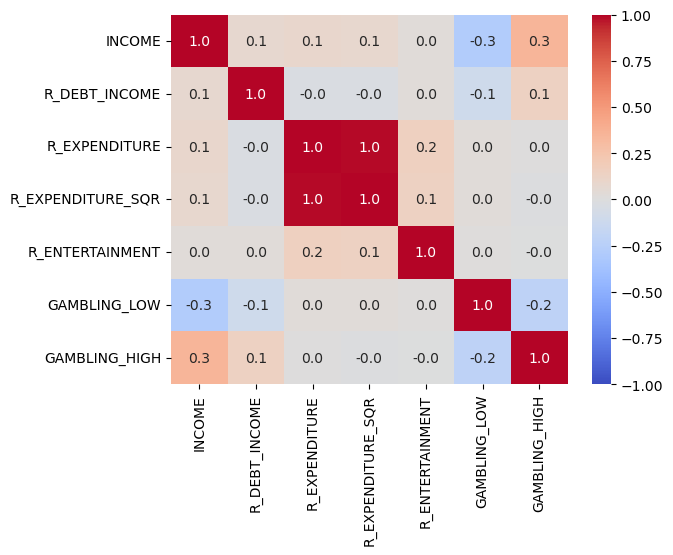

In [6]:
# Figure 4

# Correlation matrix
corr_matrix = X.drop('const',axis=1).corr()
sns.heatmap(corr_matrix, cmap="coolwarm", fmt=".1f", vmin=-1, vmax=1,annot=True)

In [7]:
# Figure 4, Lets-Plot

corr_plot(X).tiles().labels(color="black").palette_gradient(low="#2166ac", mid="#f7f7f7", high="#b2182b").build() + ggsize(700, 700)

Our model has two highly correlated features also known as a multicollinearity. This is to be expected as one of the features is the square of the other. In general, a good model should not have multicollinearity. Highly correlated features suggest we have redundant features in the model. They can also make the model harder to explain. Changes in one feature will cause changes in another and we cannot talk about feature trends in isolation.

### Plot 3: weight plot

This next plot can tell us a bit about how the model is making those predictions. For every feature, we plot a point for its “weight” or coefficient (line 2). These are taken directly from the model summary. We also plot error bars using the standard error for those coefficients (line 3). [1 :][:: −1] will exclude the model intercept from these values and reverse the order of the features. We can see the result in Figure 5.

Text(0.5, 0, 'Coefficient (Weight)')

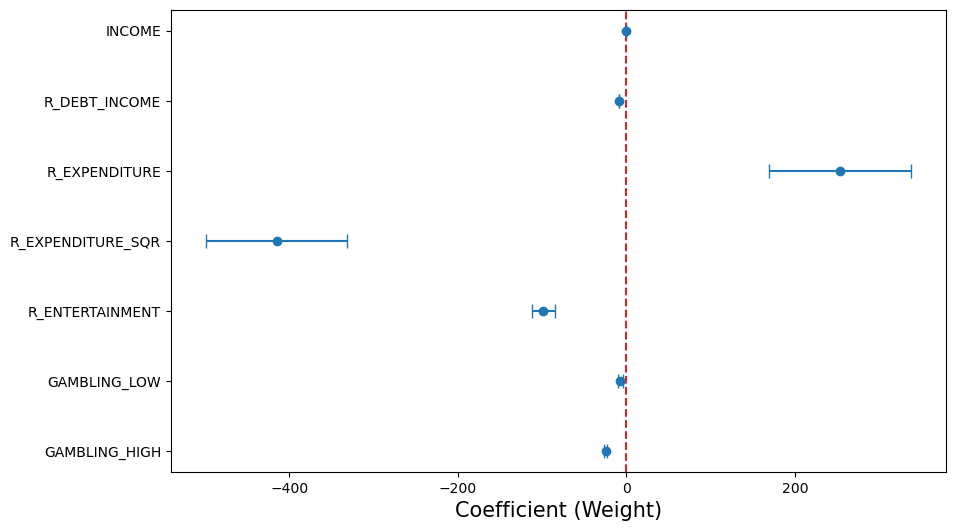

In [8]:
# Figure 5

# Get coefficients and standard errors
coefficients = model.params[1:][::-1]
se = model.bse[1:][::-1]
features = X.columns[1:][::-1]

plt.figure(figsize=(10, 6))

# Plot vertical dotted line at x=0
plt.axvline(x=0, color='tab:red', linestyle='--')

# Plot the coefficients and error bars
plt.errorbar(coefficients, 
             features, 
             xerr=se, 
             fmt='o', 
             capsize=5)

plt.xlabel('Coefficient (Weight)', size=15)

In [9]:
# Figure 5, Lets-Plot
# TODO: Errorbar-stat

ggplot() + \
    geom_vline(xintercept=0, linetype='dashed', color="red") + \
    geom_errorbar(aes(xmin=(coefficients-se).values, xmax=(coefficients+se).values, y=features.values)) + \
    geom_point(aes(x=coefficients.values, y=features.values), size=5) + \
    xlab("Coefficient (Weight)") + ylab("") + \
    ggsize(900, 450)

For each feature, the weight plot tells us how a 1-unit change in the feature’s value will change the predicted credit score. The error bars give us an indication of how certain we are about that trend. The issue with this plot is that the features will all have different scales. For example, we can expect income values to be larger than the ratios. As a result, the coefficient for income will be smaller. So, we must not interpret larger values in the weight plot to mean that a feature is more important to a prediction. The effect on the credit score will depend on the coefficient and the feature’s value.

### Plot 4: effect plot

This brings us to the effect plot. We start by calculating the feature effects for every customer. These are the feature values multiplied by the coefficients (line 2). The result will be a matrix with shape (1000, 8). For each of the 1000 customers, we have the effect of the 7 model features and 1 constant. These tell us how these features have changed the predicted credit score for that customer.

In [10]:
# Calculate the feature effects 
feature_effects = X * model.params
feature_effects.head()

,const,INCOME,R_DEBT_INCOME,R_EXPENDITURE,R_EXPENDITURE_SQR,R_ENTERTAINMENT,GAMBLING_LOW,GAMBLING_HIGH
0,674.954489,2.998018,-148.096508,146.738850,-139.386828,-49.863710,-0.0,-24.823275
1,674.954489,6.953051,-37.865500,90.620163,-53.159537,-49.637280,-0.0,-0.000000
2,674.954489,2.786069,-160.129349,144.232874,-134.666640,-60.820928,-0.0,-24.823275
3,674.954489,7.268362,-72.197047,126.184780,-103.073129,-50.149208,-0.0,-24.823275
4,674.954489,13.514555,-148.096508,116.540567,-87.919612,-50.700514,-0.0,-24.823275


We add the effects of some of the related features (lines 2–3). This will give us a clearer insight into the effect of the base feature. For example, we will have 1 effect for gambling instead of individual effects for the two one-hot encodings. We drop the constant and unnecessary features (line 4). We then plot a boxplot of the effects for each feature (lines 7–10). The result can be seen in Figure 6.

Text(0.5, 0, 'Effect on Credit Score')

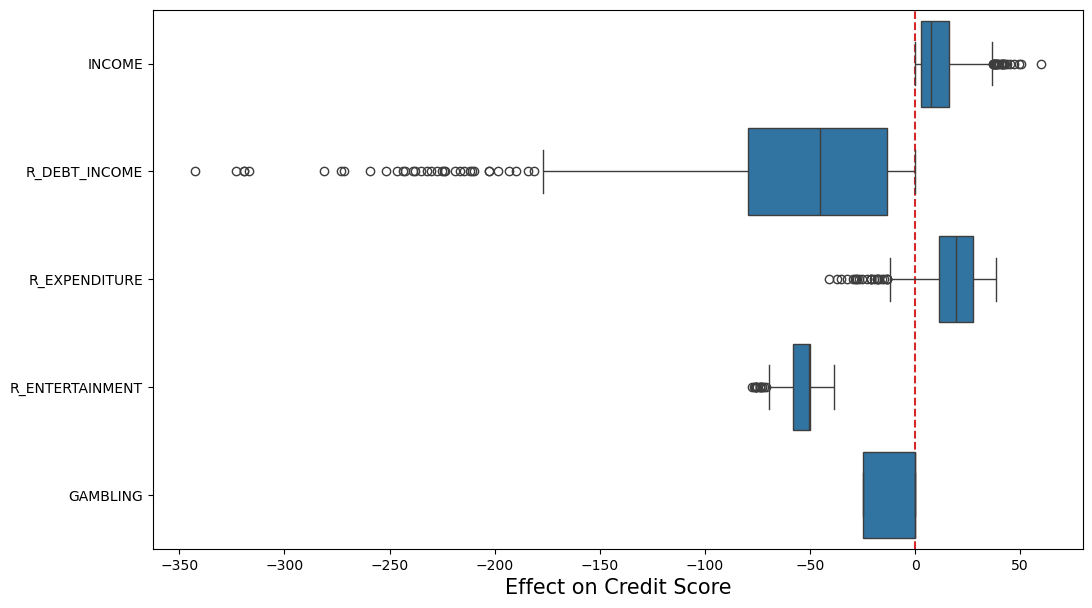

In [11]:
# Figure 6

# Combine feature effects for related features
feature_effects['R_EXPENDITURE'] = feature_effects['R_EXPENDITURE'] + feature_effects['R_EXPENDITURE_SQR']
feature_effects['GAMBLING'] = feature_effects['GAMBLING_LOW']+feature_effects['GAMBLING_HIGH']
feature_effects.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=1,inplace=True)

# Create effect plots using boxplots
plt.figure(figsize=(12, 7))
plt.axvline(x=0, color='tab:red', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue")
plt.xlabel("Effect on Credit Score", size=15)

In [12]:
# Figure 6, Lets-Plot

ggplot(feature_effects.stack().to_frame("effect").reset_index(level=1)) + \
    geom_vline(xintercept=0, linetype='dashed', color="red") + \
    geom_boxplot(aes("effect", "level_1"), fill="#0571b0", outlier_shape=1) + \
    xlab("Effect on Credit Score") + \
    ggsize(1000, 500)

The effect plot shows which features tend to make the largest contributions to the credit score. The value of that effect also tells us the relationship that feature has with the target variable. For example, the debt-to-income ratio has negative values. As this ratio increases, we have a smaller credit score.

We can make some adjustments to the effect plot to improve its interpretation. Firstly, we exclude the tails of the boxplots using the showfliers parameter (line 16). In doing so, we only display the typical effect range for each feature. We also centre the boxplot at our regression model intercept (line 3 & 11).

Text(0.5, 0, 'Effect on Credit Score')

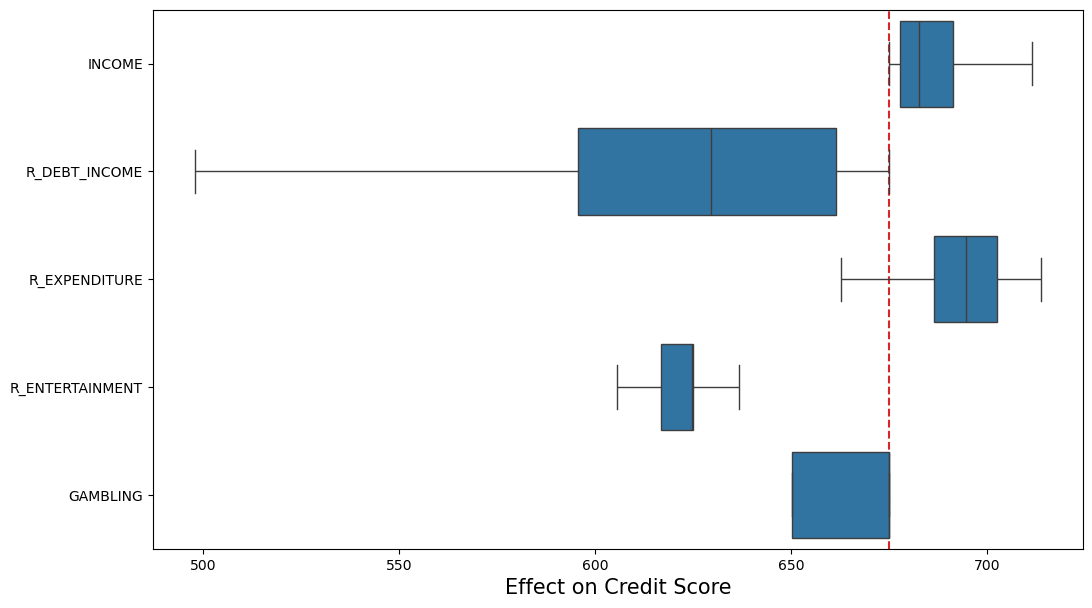

In [13]:
# Figure 7

# Calculate the feature effects
feature_effects = X * model.params
const = feature_effects['const'][0] 

# Combine feature effects for related features
feature_effects['R_EXPENDITURE'] = feature_effects['R_EXPENDITURE'] + feature_effects['R_EXPENDITURE_SQR']
feature_effects['GAMBLING'] = feature_effects['GAMBLING_LOW']+feature_effects['GAMBLING_HIGH']
feature_effects.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=1,inplace=True)

# Add the constant to the feature effects
feature_effects = feature_effects + const

# Create effect plots using boxplots
plt.figure(figsize=(12, 7))
plt.axvline(x=const, color='tab:red', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue", showfliers=False)
plt.xlabel("Effect on Credit Score", size=15)

In [14]:
# Figure 7, Lets-Plot
# TODO: Analogue of the showfliers=False

ggplot(feature_effects.stack().to_frame("effect").reset_index(level=1)) + \
    geom_vline(xintercept=const, linetype='dashed', color="red") + \
    geom_boxplot(aes("effect", "level_1"), fill="#0571b0", outlier_size=0) + \
    xlab("Effect on Credit Score") + \
    ggsize(1000, 500)

This can give some context to the effects. For example, using Figure 6, we can say that the debt-to-income ratio tends to decrease the credit score by 50 points. Now, using Figure 7, we can say this feature tends to decrease the credit score from 675 to 625.

### Plot 5: mean effect plot (feature importance)

The mean effect is created by calculating the average of the absolute of all the individual effects shown above (lines 10–11). We can see the output in Figure 8.

Text(0.5, 0, 'Mean Effect on Credit Score')

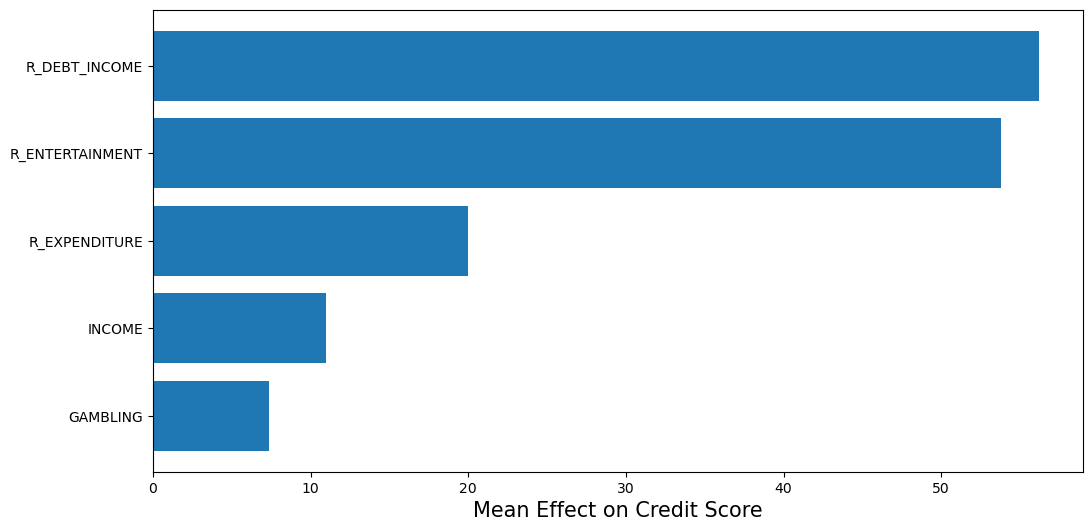

In [15]:
# Figure 8

# Calculate the feature effects 
feature_effects = X * model.params

# Combine feature effects for related features
feature_effects['R_EXPENDITURE'] = feature_effects['R_EXPENDITURE'] + feature_effects['R_EXPENDITURE_SQR']
feature_effects['GAMBLING'] = feature_effects['GAMBLING_LOW']+feature_effects['GAMBLING_HIGH']
feature_effects.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=1,inplace=True)
# Calculate the absolute values of the feature effects
feature_effects = abs(feature_effects)
mean_effects = feature_effects.mean(axis=0)
# Sort by mean effect
mean_effects.sort_values(inplace=True)
# Create a bar plot for feature importance
plt.figure(figsize=(12, 6))
plt.barh(mean_effects.index, mean_effects)
plt.xlabel('Mean Effect on Credit Score', size=15)

In [16]:
# Figure 8, Lets-Plot
# TODO: What to do with ordering?

ggplot(feature_effects.stack().to_frame("effect").reset_index(level=1), aes("effect", "level_1")) + \
    stat_summary(orientation='y', fun='mean', geom='bar') + \
    scale_y_discrete("", breaks=["GAMBLING", "INCOME", "R_EXPENDITURE", "R_ENTERTAINMENT", "R_DEBT_INCOME"]) + \
    ggsize(1000, 500)

This provides similar information to the previous plot. In fact, it provides less information. It ignores the nature of the relationships and we no longer see the spread of effect. Yet, it is still useful for focusing on one question — which feature has the most effect? In other words, we can use this plot as a measure of feature importance.

The effect and mean effect plots are both used for global explanations. They can tell us how the features contribute to the predicted credit score in general. Another global method, that requires some statistical knowledge, is the absolute t-statistic. But, what if we have a disgruntled customer demanding a reason for their low credit score? In other words, they want a local explanation. Well, this is where the individual effect plots come in.

### Plot 6: individual effect plot

The individual effect plot is simply an effect plot that is annotated with the effects for one instance (lines 7–18). That is the contribution of each feature to the prediction for that customer. For our plot, we have used a red X to mark the effects (lines 17–18) for the first customer in the dataset (line 7).

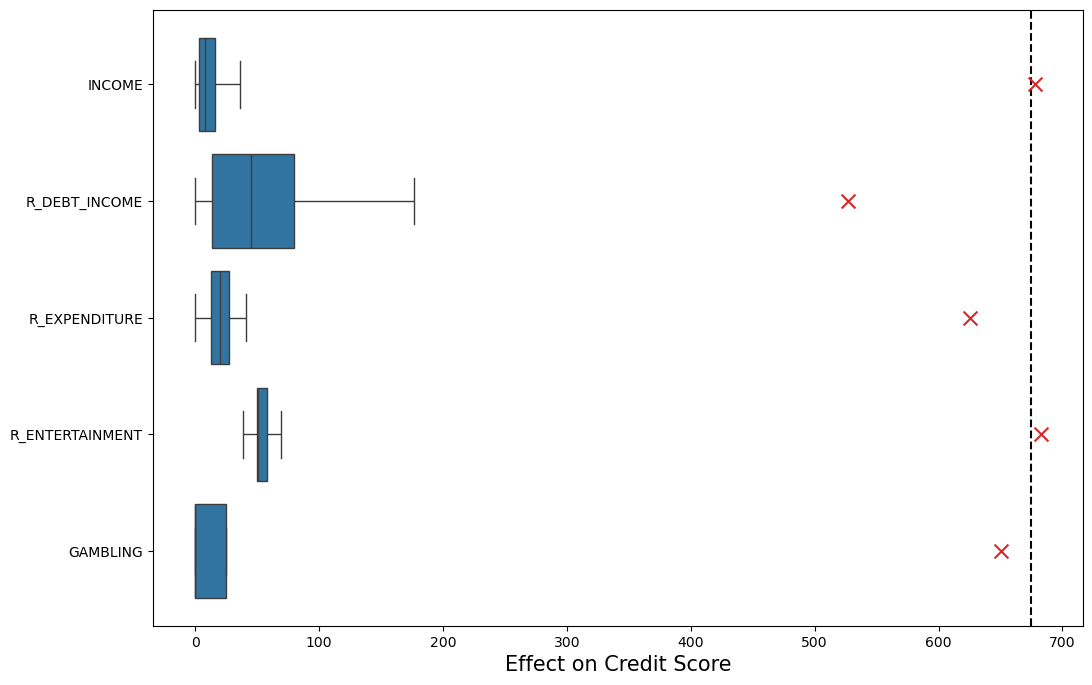

In [17]:
# Figure 9

# Create effect plots using boxplots
plt.figure(figsize=(12, 8))
plt.axvline(x=const, color='black', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue", showfliers=False)
plt.xlabel("Effect on Credit Score", size=15)

idx = 0  # You can change this to any valid index in your dataset
ind_feature_effect = X.iloc[idx] * model.params[1:]

# Combine feature effects for related features
ind_feature_effect['R_EXPENDITURE'] = ind_feature_effect['R_EXPENDITURE'] + ind_feature_effect['R_EXPENDITURE_SQR']
ind_feature_effect['GAMBLING'] = ind_feature_effect['GAMBLING_LOW']+ind_feature_effect['GAMBLING_HIGH']
ind_feature_effect.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=0,inplace=True)

# Add the constant to the feature effects
ind_feature_effect = ind_feature_effect + const
for i, feature in enumerate(ind_feature_effect):
    plt.scatter(feature, i, c='tab:red', marker='x', s=100, zorder=10)

In [18]:
# Figure 9, Lets-Plot

ggplot(feature_effects.stack().to_frame("effect").reset_index(level=1)) + \
    geom_vline(xintercept=const, linetype='dashed') + \
    geom_boxplot(aes("effect", "level_1"), fill="#0571b0", outlier_size=0) + \
    geom_point(aes("effect", "index"), data=ind_feature_effect.to_frame("effect").reset_index(), \
               size=5, shape=4, color="red") + \
    xlab("Effect on Credit Score") + \
    ggsize(1000, 500)

As seen in Figure 9, we can use this plot to find the most significant feature for the given customer.

“Why is my credit score so low?”

“Well, a major factor is your debt-to-income ratio and expenditure behaviour.”

In general, these allow us to contrast a customer against the general population.

When answering questions like the one above, it can be useful to pair the individual effect plot with plots of the feature distributions. For example, Figure 10 shows the distribution of R_DEBT_INCOME. We can see the customer has a relatively large value for this feature. We can now say, “Your debt-to-income ratio is larger than what we typically see. We are not sure you will be able to afford any more debt repayments. This is why your credit score is so low”.

The individual effect plot is not limited to only one customer. In Figure 11, we have another customer given by the blue X along with the original customer given by the red X. This is useful for contrasting the two customers. We can answer questions like, “Why was she given a loan but not me?” (after considering GDPR!)

### Plot 7: effect trend plot

Going back to global explanations, the effect plot is limited in its ability to explain trends between the features and target variables. That is we cannot tell how the effects change as feature values change. To see this, we can plot a feature’s effect vs its value (line 6).

Text(0, 0.5, 'Effect on Credit Score')

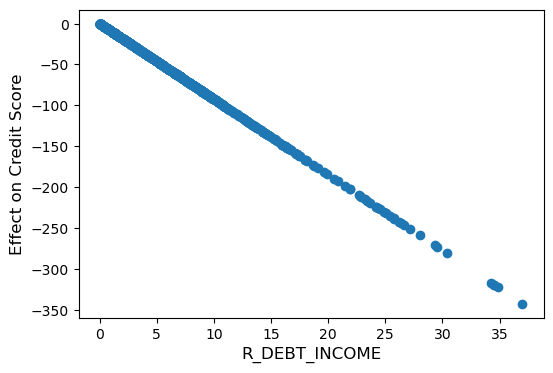

In [19]:
# Figure 12

# Calculate the feature effects 
feature_effects = X * model.params

# Plot effect of R_DEPT_INCOME
plt.figure(figsize=(6, 4))
plt.scatter(X['R_DEBT_INCOME'], feature_effects['R_DEBT_INCOME'])

plt.xlabel('R_DEBT_INCOME', size=12)
plt.ylabel('Effect on Credit Score', size=12)

In [20]:
# Figure 12, Lets-Plot

ggplot() + \
    geom_point(aes(x=X['R_DEBT_INCOME'], y=feature_effects['R_DEBT_INCOME'])) + \
    xlab("R_DEBT_INCOME") + ylab("Effect on Credit Score")

For example, we see the effect trend for R_DEBT_INCOME in Figure 12. The slope of this line is equal to -9.256. This is the model coefficient for this feature that we saw in Figure 2. We can now understand what the coefficient means in terms of the effect on the predicted credit score.

Until now, we have explored model-specific methods — they can only be used for regression models. This is because we have used the model’s coefficients to explain how it is making predictions. As a result, you will not be able to use the same methods for models like decision trees, random forests or neural networks. For these, we must use other model-specific methods or we can use model agnostic methods. The latter can be applied to any machine learning model. We end by applying by applying one model agnostic method — SHAP.

### Plot 8: SHAP values

It may seem like overkill to apply SHAP to linear regression. It is usually used for non-linear models. Still, the SHAP package can provide similar information to the above plots with less work. Also, if you have applied many models (both linear and non-linear), SHAP can provide a consistent method for comparing these. If you want a more detailed explanation of the method then see this article:

Below we calculate the SHAP values using the KernelExplainer (lines 2–3). We then output the values for one of the customers using the waterfall plot. (line 5). You can see the results in Figure 13. The arrows give the contribution of each feature to the predicted credit score (i.e. f(x) = 462.521).

In [21]:
# Calculate SHAP values
explainer = shap.KernelExplainer(model.predict,X)
shap_values = explainer(X)

shap.plots.waterfall(shap_values[0], show=False)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|███████████████████████████████████████| 1000/1000 [04:02<00:00,  4.12it/s]


<Axes: >

The waterfall plot provides similar information to the individual effect plot we saw in Figure 9. A key difference is the base value. In the effect plot, we used 0 or the intercept of the model. SHAP plot uses the average predicted credit score across all the customers (i.e. E[f(X)] = 586.71). You can confirm this using the code below.

In [22]:
preds = model.predict(X)

# calculate average prediction
print(np.mean(preds))

586.7119999999953


In general, SHAP values are useful due to their interpretation. That is they give the contribution of a feature to a prediction. For linear models, this is similar to the feature effects we used in plots 4 to 7. And like with individual effects we can aggregate SHAP values.

The code below gives the SHAP bar plot. Each bar is calculated by taking the absolute mean SHAP value for each feature across all 1000 customers. Notice how similar these are to the mean effect plot in Figure 8. Likewise, the SHAP beeswarm plot is similar to the effect plot and the SHAP dependence plot is similar to the trend effect plot.

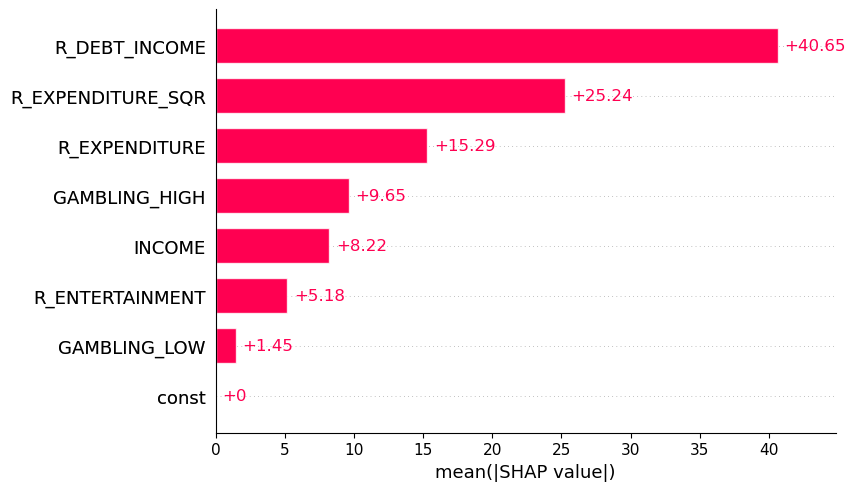

In [25]:
# Figure 14

# SHAP bar plot
shap.plots.bar(shap_values)

In [24]:
# Figure 14, Lets-Plot

ggplot(pd.DataFrame(shap_values.values, columns=X.columns).abs().mean().to_frame("mean_shap_value").reset_index()) + \
    geom_bar(aes("mean_shap_value", as_discrete("index", order_by="mean_shap_value", order=1)), stat='identity', fill="#ff0051") + \
    xlab("mean(|SHAP value|)") + ylab("") + \
    ggsize(1000, 500)

We’ve seen how:

- Residual plots help us explain model performance
- Correlation plots ensure our explanations make sense
- Effect plots ground explanations in the impact on predictions
- and SHAP plots provide an alternative view

But, applying these methods is really the last step in explaining a model. To make your job easier, you need to focus on building a model that is easy to explain. This involves removing redundant features and only including features that have intuitive relationships. In summary, interpretability starts with your data. These resources will help with this process:

YouTube video: Interpretable Feature Engineering | How to Build Intuitive Machine Learning Features